# **Install Dependencies**

In [ ]:
!pip install gurobipy==10.0.0 matplotlib==3.5.2 numpy==1.21.5 pandas==1.4.4 scikit-learn==1.2.1

# **fragility_index.py**

In [2]:
# %load /kaggle/input/frazileindex-files/fragility_index.py
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

def Data_load(data_name):        
    if data_name == 'BreastCancerCoimbra':
        data = pd.read_excel('/kaggle/input/datamining/Data/Breast Cancer Coimbra Data Set .xlsx')
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1]==1 else -1 for i in range(data.values[:,-1].shape[0])])
        
    elif data_name == 'BreastCancerPrognostic':
        data = pd.read_excel('/kaggle/input/datamining/Data/Breast Cancer Wisconsin Prognostic .xlsx',header=None)
        data.fillna(method= 'ffill', inplace=True)
        x = data.values[:,1:]
        y = np.array([1 if data.values[i,0]=='N' else -1 for i in range(data.values[:,0].shape[0])])

    elif data_name == 'LiverPatient':
        data = pd.read_csv('/kaggle/input/datamining/Data/Indian Liver Patient Dataset (ILPD).csv',engine="python",header=None)
        data[1] = [1 if data.values[i,1] == 'Male' else 0 for i in range(data.values.shape[0])]
        data.fillna(method= 'ffill', inplace=True)
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1]==1 else -1 for i in range(data.values[:,-1].shape[0])])
    
    elif data_name == 'GermanCredit':
        data = pd.read_excel('/kaggle/input/datamining/Data/GermanCredit.xlsx',header=None)
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1] ==1 else -1 for i in range(data.values[:,-1].shape[0])])
    
    elif data_name == 'LiverDisorders':
        data = pd.read_excel('/kaggle/input/datamining/Data/LiverDisorders.xlsx',header=None)
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1] ==1 else -1 for i in range(data.values[:,-1].shape[0])])
    elif data_name=="Australian":
        data = pd.read_csv('/kaggle/input/datamining/Data/Australian Credit Approval.csv')
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1] ==1 else -1 for i in range(data.values[:,-1].shape[0])])
    
    elif data_name=="Diabetes":
        data = pd.read_csv('/kaggle/input/datamining/Data/Diabetes dataset.csv')
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1] ==1 else -1 for i in range(data.values[:,-1].shape[0])])
    
    elif data_name=="Ionosphere":
        data = pd.read_csv('/kaggle/input/datamining/Data/Johns Hopkins University Ionosphere database.csv',header=None)
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1] =='g' else -1 for i in range(data.values[:,-1].shape[0])])
    elif data_name=='SpamBase':
        data = pd.read_csv('/kaggle/input/datamining/Data/SPAM E-MAIL DATABASE ATTRIBUTES.csv',header=None)
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1] ==1 else -1 for i in range(data.values[:,-1].shape[0])])
    elif data_name=='Sonar':
        data = pd.read_csv('/kaggle/input/datamining/Data/Sonar.csv',header=None)
        x = data.values[:,:-1]
        y = np.array([1 if data.values[i,-1] =='R' else -1 for i in range(data.values[:,-1].shape[0])])
    else:
        print('No data')
        
    return x,y

def FI_calculation(score,y):
    """
    Calculate the KL-divergence based FI by Algorithm 1
    Input:
        score: score value h(x) of each test sample x.
        y: true class label.
        
    Output:
        value of FI
    """
    
    sample_p = score[y==1]      # positive samples
    sample_n = score[y==-1]      # negative samples
    
    N_p = sample_p.shape[0]
    N_n = sample_n.shape[0]
    
    S = N_p * N_n           #number of samples of ranking errors
    
    error = np.zeros(S)     # ranking error
    for i in range(N_p):
        for j in range(N_n):
            error[i * N_n + j] = sample_n[j] - sample_p[i]
            
            
    def expectation(error,k):
        # calculate the empirical expectation given the value of k
        x = 0
        for i in range(error.shape[0]):
            x += np.exp(error[i]/k)
            
        return x/error.shape[0]
    
            
    if (error<0).sum() == 0:
        return 0, error
    elif error.mean()>0:
        return np.Inf, error
    else:       
        k_min = 10
        e = expectation(error,k_min)
        while (e <= 1) & (k_min>1e-4) :
            k_min = k_min/2
            e = expectation(error,k_min)
            #print(k_min)
            
        if k_min <= 1e-4:
            return 0,error
        else:
            k_max = k_min * 2
            
            while k_max - k_min > 1e-3:
                k = (k_min + k_max) / 2
                e = expectation(error,k)
                if e <= 1:
                    k_max = k
                else:
                    k_min = k
                    
                #print(k_max,k_min)
            
            return k_max, error
    
    
 
def bAUC_calculation(samples, estimate=True):

    """
    Calculte bAUC given the samples of ranking error
    Formulation can be found in Norton M, Uryasev S. Maximization of auc and buffered auc in binary classification[J]. Mathematical Programming, 2019, 174(1): 575-612.
    """

    ################# estimate bPOE by simply sorting samples #################
    if estimate==True:
        N=samples.shape[0]
        sorted_samples=sorted(samples)
    
        cvar=sorted_samples[-1]
        probability_level=1
        for i in range(N):
            probability_level = probability_level - 1/float(N)
            cvar = (cvar*(i) + sorted_samples[-(i+1)])/float(i+1)
            if cvar <=0: break
    
        var=sorted_samples[int( probability_level*N ) ]
        bPOE=1-probability_level
        bAUC=probability_level
        # a=1/float(-var)
        gamma=var
        return bAUC
    ######################Get bAUC exactly by solving an LP#############################

    
    m = gp.Model()
    m.setParam("OutputFlag",0)

    E=[]
 
    for i in range(samples.shape[0]):
        E.append(m.addVar(lb=0,ub=GRB.INFINITY,obj=0,vtype=GRB.CONTINUOUS,name="E"+str(i) ))
    a=m.addVar(lb=0,ub=GRB.INFINITY,obj=0,vtype=GRB.CONTINUOUS,name="a" )  

    m.update()
    m.setObjective( (1/float(samples.shape[0]))*gp.quicksum(E[i] for i in range(samples.shape[0])  ),GRB.MINIMIZE)
    
    m.optimize()
    
    for i in range(samples.shape[0]):
        m.addConstr ( E[i]      >= a * (samples[i]) + 1            )
        m.addConstr ( E[i]      >= 0                               )
    
    m.optimize()
    bPOE=m.getObjective().getValue()
    bAUC=1-bPOE
        
    return bAUC
    
 
def FI_minimization(N,S,data_sample,lb_p,lb_n,ub_p,ub_n,LogToConsole=False):
    
    """
    Train linear classifier by minimizing wasserstein based FI.

    Input:
        N: dimension of features.
        data_sample: samples in the empirical distribution of ranking errors.
        S: number of samples in the empirical distribution of ranking errors.
        lb_p, ub_p: lower bound and upper bound for the features of positive samples.
        lb_n, ub_n: lower bound and upper bound for the features of negativee samples.

        
    Output:
        w_solu: decision variable for the linear classifier
    """
    
    MM = gp.Model()
    MM.Params.LogToConsole=LogToConsole

    
    k = MM.addVar(lb = 0,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="k")
    p1 = MM.addVars(S,N,lb = 0,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="p1")
    p2 = MM.addVars(S,N,lb = 0,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="p2")
    q1 = MM.addVars(S,N,lb = 0,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="q1")
    q2 = MM.addVars(S,N,lb = 0,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="q2")
    
    r = MM.addVars(S,2*N,lb = -GRB.INFINITY,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="r")
    r_abs = MM.addVars(S,2*N,lb = 0,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="r")
    
    w = MM.addVars(N,lb = -GRB.INFINITY,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS,name='w')
    w_abs = MM.addVars(N,lb = 0,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS,name='w')
    
    aux = MM.addVars(S,lb = -GRB.INFINITY,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="aux")
    
    
    MM.setObjective(k,GRB.MINIMIZE)
    
    MM.addConstr( sum( aux[s] for s in range(S) )
                  <= 0 )
    
    MM.addConstrs(sum(- p1[s,n] * lb_p[n] + p2[s,n] * ub_p[n] 
                        - q1[s,n] * lb_n[n] + q2[s,n] * ub_n[n] 
                        for n in range(N))
                    + sum(r[s,n] * data_sample[s,n]
                        for n in range(2*N))
                    == aux[s]
                  for s in range(S))
    
    MM.addConstrs(- p1[s,n] + p2[s,n] 
                  == 
                  - w[n] - r[s,n] 
                  for s in range(S) for n in range(N))
    
    MM.addConstrs(- q1[s,n] + q2[s,n] 
                  ==
                  w[n] - r[s,N+n] 
                  for s in range(S) for n in range(N))
    
    
    MM.addConstrs(r_abs[s,n] == gp.abs_(r[s,n]) for s in range(S) for n in range(2*N))
    MM.addConstrs(r_abs[s,n] <= k for s in range(S) for n in range(2*N))
    
    

    MM.addConstrs(w_abs[n] == gp.abs_(w[n]) for n in range(N))
    MM.addConstr(gp.quicksum(w_abs[n] for n in range(N)) == 1 )

    MM.optimize()

    
    w_solu = np.zeros(N)
    for n in range(N):
        w_solu[n] = w[n].x

    
    return w_solu


def bAUC(N,S,data_sample,LogToConsole=False):
    
    """
    Train linear classifier by maximizing bAUC
    Formulation can be found in Norton M, Uryasev S. Maximization of auc and buffered auc in binary classification[J]. Mathematical Programming, 2019, 174(1): 575-612.
    
    Input:
        N: dimension of features.
        data_sample: samples in the empirical distribution of ranking errors.
        S: number of samples in the empirical distribution of ranking errors.
        
    Output:
        w_solu: decision variable for the linear classifier
    """
    
    MM = gp.Model()
    MM.Params.LogToConsole=LogToConsole
    
    
    w = MM.addVars(N,lb = -GRB.INFINITY,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS,name='w')
    w_abs = MM.addVars(N,lb = 0,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS,name='w')

    r = MM.addVars(S,lb = 0,ub = GRB.INFINITY,vtype=GRB.CONTINUOUS,name="r")
    
    MM.setObjective(gp.quicksum(r[s] for s in range(S)),GRB.MINIMIZE)
    
    MM.addConstrs(r[s] >= 
                  sum(w[n]*(data_sample[s,N+n]-data_sample[s,n]) for n in range(N)) +1
                  for s in range(S))
    

    MM.addConstrs(w_abs[n] == gp.abs_(w[n]) for n in range(N))
    MM.addConstr(gp.quicksum(w_abs[n] for n in range(N)) == 1 )
    
    MM.setParam("NonConvex", 2)
    
    MM.optimize()
    
    w_solu = np.zeros(N)
    for n in range(N):
        w_solu[n] = w[n].x
    
    return w_solu

     

def performance(data_name,name,w,N,S_test,data_test):
    """
    For section 5.3 Optimization for linear classifiers.
    Calculating the statistic descriptions of ranking errors.
    
    Output: performance table
    """
    ranking_error = np.zeros(S_test)
    for s in range(S_test):
        ranking_error[s] = w.dot(data_test[s,N:]) - w.dot(data_test[s,:N])
    
    # ranking_error_pos = ranking_error[ranking_error >= 0]
    
    v_prob = np.mean(ranking_error <= 0)
    v_mean = np.mean(ranking_error[ranking_error >= 0])
    v_std = np.std(ranking_error)
    v_var95 = np.quantile(ranking_error, 0.95)
    v_var99 = np.quantile(ranking_error, 0.99)
    v_cvar95 = np.mean(ranking_error[ranking_error>=v_var95])
    v_cvar99 = np.mean(ranking_error[ranking_error>=v_var99])
    
    perf_df = pd.DataFrame({"Data_name":[data_name],
                            "Model_name": [name], 
                            "Probability": [v_prob],
                            "Mean": [v_mean],
                            "Std": [v_std],
                            "VaR%95": [v_var95],
                            "CVaR%95": [v_cvar95],
                            "VaR%99": [v_var99],
                            "CVaR%99": [v_cvar99]})
        
    return perf_df

def calculate_error(classifier, x, y):
    score = classifier.decision_function(x)

    sample_p = score[y==1]      # positive samples
    sample_n = score[y==-1]      # negative samples
    
    N_p = sample_p.shape[0]
    N_n = sample_n.shape[0]
    
    S = N_p * N_n           #number of samples of ranking errors
    
    error = np.zeros(S)     # ranking error
    for i in range(N_p):
        for j in range(N_n):
            error[i * N_n + j] = sample_n[j] - sample_p[i]
    
    return error


def performance_of_error(data_name, name, ranking_error):
    v_prob = np.mean(ranking_error <= 0)
    v_mean = np.mean(ranking_error[ranking_error >= 0])
    v_std = np.std(ranking_error)
    v_var95 = np.quantile(ranking_error, 0.95)
    v_var99 = np.quantile(ranking_error, 0.99)
    v_cvar95 = np.mean(ranking_error[ranking_error>=v_var95])
    v_cvar99 = np.mean(ranking_error[ranking_error>=v_var99])
    
    perf_df = pd.DataFrame({"Data_name":[data_name],
                            "Model_name": [name], 
                            "AUC": [v_prob],
                            "Mean": [v_mean],
                            "Std": [v_std],
                            "VaR%95": [v_var95],
                            "CVaR%95": [v_cvar95],
                            "VaR%99": [v_var99],
                            "CVaR%99": [v_cvar99]})
        
    return perf_df

    

# **Import Necessary Libraries**

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# **------------------------------------------------------------**
# **Classifiers:**
# **------------------------------------------------------------**
#              **1. Decision Tree (DT)**
#              **2. Random Forest (RF)**
#              **3. GaussianNB (GNB)**
#              **4. K-Nearest Neighbors (KNN)**
#              **5. AdaBoost (AD)**
#              **6. Gradient Boosting (GB)**
# **------------------------------------------------------------**

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# **------------------------------------------------------------**
# **Dataset: Diabetes** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.670863  0.341624  0.678131  0.703247   0.580392   
0         Random Forest  0.831749  0.591160  0.176727  0.766883   0.703644   
0  Gaussian Naive Bayes  0.822378  0.522203  0.277954  0.758766   0.674905   
0   K-Nearest Neighbors  0.693452  0.386774  1.100494  0.739286   0.653948   
0              AdaBoost  0.814391  0.417505  0.057281  0.751948   0.670343   
0     Gradient Boosting  0.831405  0.570552  0.223724  0.766558   0.692075   

     Recall                                  TN_and_FP  \
0  0.560302  [0.5084415584415584, 0.14253246753246754]   
0  0.579302  [0.5652597402597404, 0.08571428571428573]   
0  0.601399  [0.5490259740259741, 0.10194805194805197]   
0  0.538799  [0.5519480519480521, 0.09902597402597405]   
0  0.570289  [0.5529220779220779, 0.09805194805194807]   
0  0.602696  [0.5568181818181819, 0.09415584415584417]   

                                    FN_and_TP 

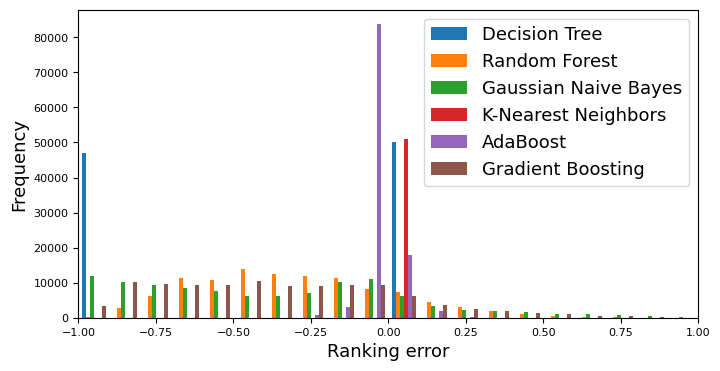

In [4]:
N_seeds = 20  # number of seeds
data_name = 'Diabetes'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()

# **------------------------------------------------------------**
# **Dataset: Breast Cancer Coimbra** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.714474  0.427458  0.550598  0.712500   0.710735   
0         Random Forest  0.809431  0.555798  0.171783  0.720833   0.716568   
0  Gaussian Naive Bayes  0.764118  0.380359  0.445221  0.633333   0.579324   
0   K-Nearest Neighbors  0.753168  0.525982  0.956940  0.743750   0.717650   
0              AdaBoost  0.785871  0.479498  0.090332  0.729167   0.722526   
0     Gradient Boosting  0.835479  0.572557  0.277374  0.756250   0.764900   

     Recall                                   TN_and_FP  \
0  0.676634               [0.39375, 0.1333333333333334]   
0  0.677632   [0.4020833333333333, 0.12500000000000003]   
0  0.860738                   [0.2270833333333333, 0.3]   
0  0.782743  [0.37708333333333327, 0.15000000000000005]   
0  0.695105  [0.39999999999999986, 0.12708333333333333]   
0  0.693484  [0.42499999999999993, 0.10208333333333337]   

                                    FN_

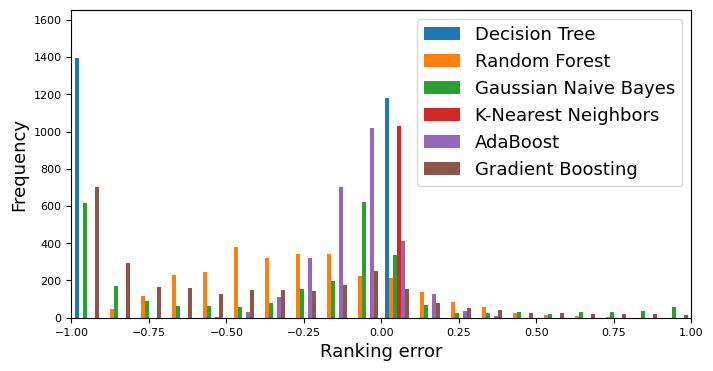

In [5]:
N_seeds = 20  # number of seeds
data_name ='BreastCancerCoimbra'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()

# **------------------------------------------------------------**
# **Dataset: Liver Disorders** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.650098  0.299725  0.863831  0.652899   0.619942   
0         Random Forest  0.757879  0.454886  0.198242  0.713043   0.749947   
0  Gaussian Naive Bayes  0.637990  0.147003  1.756561  0.551449   0.505487   
0   K-Nearest Neighbors  0.579479  0.162763       inf  0.589130   0.557397   
0              AdaBoost  0.754243  0.272456  0.121826  0.699275   0.692157   
0     Gradient Boosting  0.764894  0.457023  0.269287  0.700725   0.705201   

     Recall                                   TN_and_FP  \
0  0.609703   [0.3804347826086957, 0.16956521739130437]   
0  0.552512   [0.4652173913043478, 0.08478260869565218]   
0  0.739312  [0.21956521739130433, 0.33043478260869574]   
0  0.455207   [0.38550724637681166, 0.1644927536231884]   
0  0.596259    [0.4304347826086956, 0.1195652173913044]   
0  0.583537  [0.43840579710144933, 0.11159420289855075]   

                                    FN_

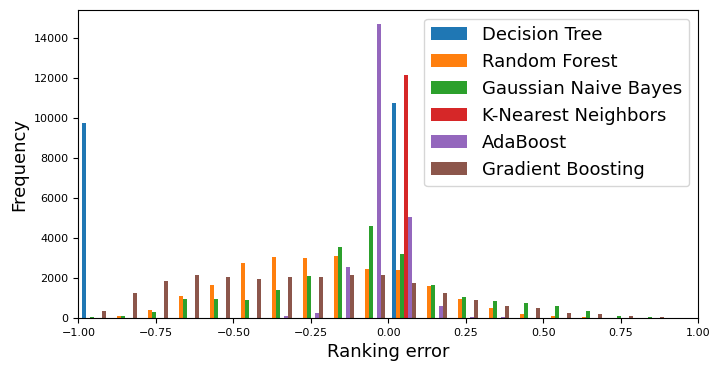

In [6]:
N_seeds = 20  # number of seeds
data_name = 'LiverDisorders'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()

# **------------------------------------------------------------**
# **Dataset: Indian Liver Patient** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.584524  0.168888  1.459778  0.659402   0.761446   
0         Random Forest  0.742094  0.399119  0.216644  0.703846   0.759849   
0  Gaussian Naive Bayes  0.730058  0.352108  0.354645  0.550000   0.948402   
0   K-Nearest Neighbors  0.561437  0.122640  4.579681  0.664103   0.745307   
0              AdaBoost  0.723761  0.299561  0.067047  0.697009   0.763200   
0     Gradient Boosting  0.718714  0.316170  0.334595  0.693162   0.749977   

     Recall                                    TN_and_FP  \
0  0.761159    [0.11709401709401712, 0.1700854700854701]   
0  0.854048   [0.09487179487179485, 0.19230769230769226]   
0  0.390656  [0.27136752136752146, 0.015811965811965815]   
0  0.803362   [0.09145299145299145, 0.19572649572649573]   
0  0.834208   [0.10256410256410255, 0.18461538461538457]   
0  0.853554   [0.08461538461538463, 0.20256410256410254]   

                                

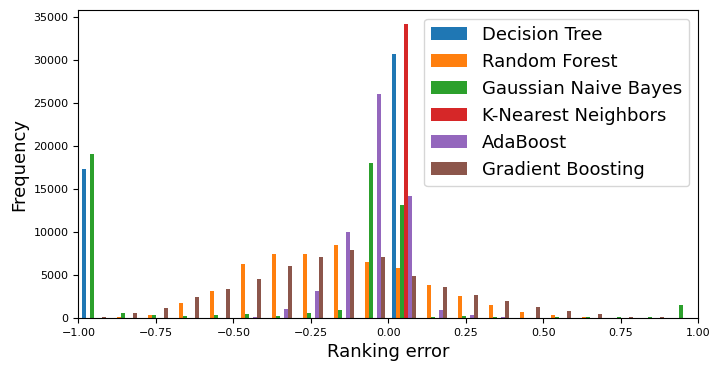

In [7]:
N_seeds = 20  # number of seeds
data_name = 'LiverPatient'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()

# **------------------------------------------------------------**
# **Dataset: German Credit** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.632879  0.265722  0.883636   0.69000   0.780347   
0         Random Forest  0.783283  0.491129  0.169830   0.75800   0.780043   
0  Gaussian Naive Bayes  0.752801  0.415764  0.388611   0.72675   0.825799   
0   K-Nearest Neighbors  0.605540  0.211031  1.693848   0.71075   0.754497   
0              AdaBoost  0.776390  0.408177  0.048889   0.76275   0.807063   
0     Gradient Boosting  0.784474  0.483679  0.228271   0.76975   0.805134   

     Recall                                   TN_and_FP  \
0  0.775745  [0.14725000000000002, 0.15300000000000005]   
0  0.911061  [0.12050000000000005, 0.17975000000000005]   
0  0.772533  [0.18600000000000003, 0.11425000000000005]   
0  0.870107  [0.10200000000000004, 0.19825000000000007]   
0  0.868423  [0.15500000000000008, 0.14525000000000005]   
0  0.886032  [0.15000000000000005, 0.15025000000000002]   

                                   FN_a

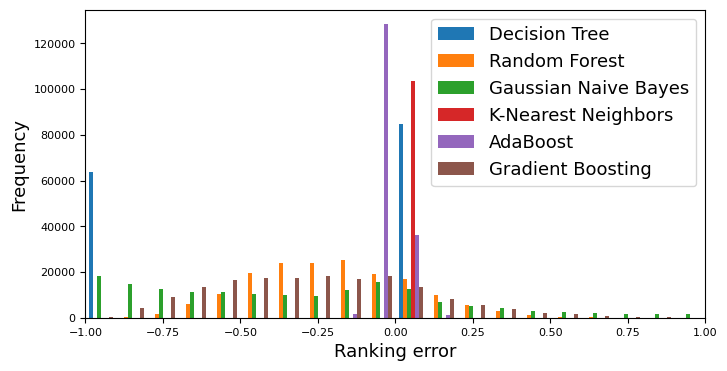

In [13]:
N_seeds = 20  # number of seeds
data_name = 'GermanCredit'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()

# **------------------------------------------------------------**
# **Dataset: Breast Cancer Wisconsin Prognostic** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.601063  0.216817       inf   0.69875   0.828241   
0         Random Forest  0.654825  0.267894  0.281128   0.81750   0.819207   
0  Gaussian Naive Bayes  0.636897  0.199227       inf   0.68625   0.840880   
0   K-Nearest Neighbors  0.616727  0.328696  1.428650   0.79500   0.825384   
0              AdaBoost  0.734625  0.368538       inf   0.76625   0.841856   
0     Gradient Boosting  0.739716  0.386834  0.405518   0.80875   0.846896   

     Recall                                    TN_and_FP  \
0  0.775969   [0.09125000000000003, 0.12625000000000003]   
0  0.984236  [0.047500000000000014, 0.17000000000000004]   
0  0.734231                  [0.11, 0.10750000000000004]   
0  0.933560   [0.06375000000000001, 0.15375000000000005]   
0  0.862580   [0.09125000000000001, 0.12625000000000003]   
0  0.919368               [0.08875000000000002, 0.12875]   

                                

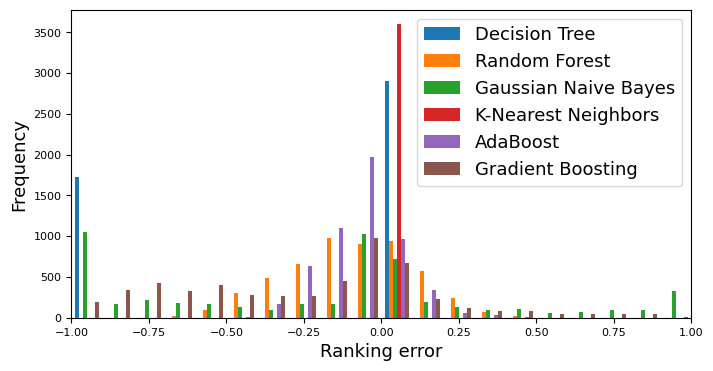

In [9]:
N_seeds = 20  # number of seeds
data_name = 'BreastCancerPrognostic'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()

# **------------------------------------------------------------**
# **Dataset: Australian Cretdit Approval** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.817104  0.634113  0.334473  0.817754   0.790144   
0         Random Forest  0.932784  0.831697  0.141724  0.865580   0.843997   
0  Gaussian Naive Bayes  0.891672  0.619957  0.282379  0.800000   0.847520   
0   K-Nearest Neighbors  0.833819  0.667543  0.613220  0.835507   0.824216   
0              AdaBoost  0.910023  0.724050  0.026093  0.844565   0.816094   
0     Gradient Boosting  0.934898  0.824697  0.163727  0.857609   0.829763   

     Recall                                   TN_and_FP  \
0  0.809682  [0.45471014492753625, 0.09673913043478259]   
0  0.863014  [0.47898550724637684, 0.07246376811594205]   
0  0.677294   [0.4960144927536232, 0.05543478260869566]   
0  0.809473   [0.4728260869565218, 0.07862318840579711]   
0  0.845992   [0.4655797101449275, 0.08586956521739132]   
0  0.862110   [0.4713768115942029, 0.08007246376811594]   

                                    FN_

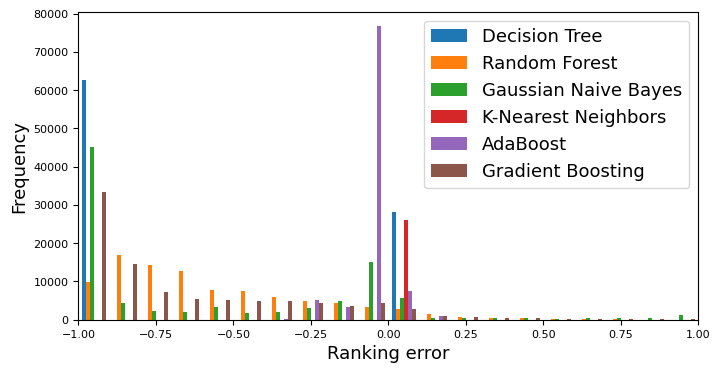

In [10]:
N_seeds = 20  # number of seeds
data_name = 'Australian'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()

# **------------------------------------------------------------**
# **Dataset: Johns Hopkins University Ionosphere** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.874887  0.749506  0.246155  0.886620   0.911001   
0         Random Forest  0.989408  0.969939  0.052795  0.944366   0.945760   
0  Gaussian Naive Bayes  0.949779  0.770886  0.152069  0.889437   0.875684   
0   K-Nearest Neighbors  0.805676  0.805362  0.246948  0.858451   0.829724   
0              AdaBoost  0.957496  0.892912  0.032593  0.932394   0.924920   
0     Gradient Boosting  0.980600  0.923712  0.092255  0.938028   0.933103   

     Recall                                    TN_and_FP  \
0  0.915910    [0.2887323943661972, 0.05845070422535211]   
0  0.970269    [0.3112676056338028, 0.03591549295774648]   
0  0.970018    [0.25633802816901413, 0.0908450704225352]   
0  0.984922   [0.21549295774647886, 0.13169014084507044]   
0  0.975421  [0.29577464788732394, 0.051408450704225346]   
0  0.975249   [0.30140845070422534, 0.04577464788732395]   

                                

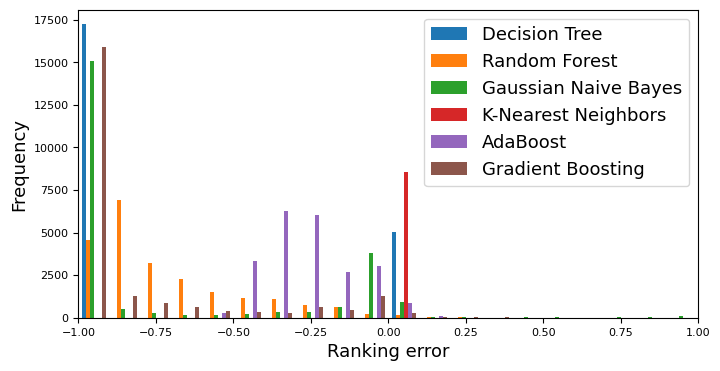

In [11]:
N_seeds = 20  # number of seeds
data_name = 'Ionosphere'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()

# **------------------------------------------------------------**
# **Dataset: Sonar** 
# **------------------------------------------------------------**

                   name       AUC      bAUC        FI  Accuracy  Precision  \
0         Decision Tree  0.710613  0.420419  0.570709  0.711905   0.713809   
0         Random Forest  0.929139  0.829736  0.058899  0.827381   0.880045   
0  Gaussian Naive Bayes  0.776984  0.353891  0.656342  0.663095   0.611618   
0   K-Nearest Neighbors  0.795220  0.626618  0.609314  0.797619   0.856466   
0              AdaBoost  0.866750  0.683119  0.032410  0.804762   0.803793   
0     Gradient Boosting  0.905706  0.714867  0.211975  0.819048   0.845780   

     Recall                                    TN_and_FP  \
0  0.651977   [0.40357142857142847, 0.12380952380952381]   
0  0.735082   [0.48095238095238085, 0.04642857142857143]   
0  0.787269    [0.2904761904761905, 0.23690476190476187]   
0  0.693899  [0.47142857142857125, 0.055952380952380934]   
0  0.775641   [0.43809523809523804, 0.08928571428571429]   
0  0.748347    [0.4642857142857142, 0.06309523809523811]   

                                

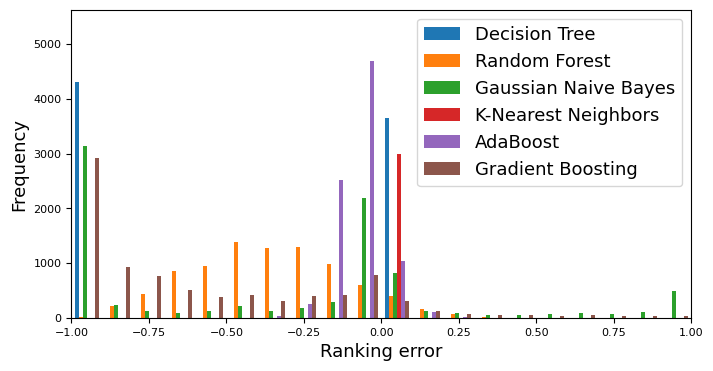

In [12]:
N_seeds = 20  # number of seeds
data_name = 'Sonar'

dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
adaboost = AdaBoostClassifier(n_estimators=50)
gb = GradientBoostingClassifier()

model_name_list = np.array(
    [[dt, 'Decision Tree'],
     [rf, 'Random Forest'],
     [nb, 'Gaussian Naive Bayes'],
     [knn, 'K-Nearest Neighbors'],
     [adaboost, 'AdaBoost'],
     [gb, 'Gradient Boosting']])

x, y = Data_load(data_name)  # import data

perf = pd.DataFrame(columns=['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'Conf_matrix', 'error'])  # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2, 2))
    error_total = np.array([])
    for _seed in range(N_seeds):

        np.random.seed(_seed)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)

        clf.fit(X_sample, y_sample)
        if clf == knn:  # If KNN classifier, no need to predict_proba
            prob_pos = clf.predict(X_test)
        else:
            prob_pos = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
        y_predict = clf.predict(X_test)

        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = FI_calculation(prob_pos, y_test)
        bAUC = bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds

        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC / N_seeds
        FI_mean += FI / N_seeds
        bAUC_mean += bAUC / N_seeds
        error_total = np.concatenate((error_total, error))

    perf_clf = pd.DataFrame({'name': [name],
                             'AUC': [AUC_mean],
                             'bAUC': [bAUC_mean],
                             'FI': [FI_mean],
                             'Accuracy': [accuracy_mean],
                             'TN_and_FP': [conf_matrix_mean[0]],
                             'FN_and_TP': [conf_matrix_mean[1]],
                             'Precision': [precision_mean],
                             'Recall': [recall_mean],
                             'F1': [f1_mean],
                             'MCC': [mcc_mean],
                             'error': [error_total]})

    perf = pd.concat([perf, perf_clf])

print(perf[['name', 'AUC', 'bAUC', 'FI', 'Accuracy', 'Precision', 'Recall', 'TN_and_FP', 'FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values, bins=40)
plt.legend(['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'K-Nearest Neighbors', 'AdaBoost', 'Gradient Boosting'], fontsize=13)
ax = plt.gca()
ax.set_xlim(-1, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_Diabetes.png', dpi=300)
plt.show()